In [78]:
from sklearn import svm

In [ ]:
svm.LinearSVC

http://www.cs.sjsu.edu/~stamp/CS185C/projects/project.html
> Then you need to discuss what you plan to do (e.g., what algorithms and packages you'll use, and so on), and you need to tell us where the data will come from, and how you will deal with the data.

https://piazza.com/class/jkpence3iqu12p?cid=74
> There is no specific length requirement, and quality is much more important than quantity. Be sure to include brief an intro, background, and references sections, and you want to focus on what you did. Include lots of results and be sure to discuss your results.

processed 160000 articles; 69401 were english; elapsed 752.52 seconds (12.54 minutes)

In [2]:
completed = 160000
seconds = 752
total = 263166
remaining_seconds = seconds/completed * (263166-completed)
remaining_minutes = remaining_seconds/60
print(f'remaining: {remaining_seconds:.2f} ({remaining_minutes:.2f} minutes)')

remaining: 484.88 (8.08 minutes)


<a href="https://docs.google.com/document/d/1fCMA4DEt7in0N5gmBb-qeeseBp9YSwMYqhLBM4Ebm6E/edit">
    <img src="../../images/Google_Docs_Logo.jpg" style="display:inline-block">
    <strong>Final Paper Google Doc</strong></a>  
<strong><a href="https://73.222.173.223:18646/wiki/index.php/ML-IS_Project">
    <img src="../../images/mediawiki.png" style="display:inline-block">
    My Mediawiki MLIS Project page</a></strong>  
<a href="speaker-facial-recognition.ipynb">
    <strong>Student Speaker on Facial recognition (JN)</strong></a>  



<a href="https://docs.google.com/document/d/1XvhSQ5zhyLD6te5gOPYvK4DDXqOumTQAGRQAGqiqDLw/edit?usp=sharing">
    <img src="../../images/Google_Docs_Logo.jpg" style="display:inline-block">
    Project Proposal Google Doc</a>  


work in pairs  
can work individually. maybe in group of 3 but higher expectations  
1-2 treat the same  
try to find someone you can work with  
good project? he likes to see.. ideal proj.. 2 kinds of projs..  
1. take existing data and analyze it with ML techniques. expect at least couple different techniques applied. one we spent a lot of class time on, and one technique we didn't do much in class.
2. you collect the data. that's a lot of work. not as high expectations for the analysis on ML side. e.g. student last year in HS (HS students email him to ask to work with him on projects to get to harvard). he had collected some interesting data. footstep sounds of people stepping. computed statistics on them and then used that to train ML models to see if he could distinguish people as a biometric. lots of work on gait recognition but that's visual. his was audio. Stamp says it worked reasonably well.  

implementing a research paper? probably too much, more than you can do in a semester. could implement part of it. master students - first thing they often do is to base paper on a previous paper. first check if previous paper is legit - re-implement part of the paper. enough that they're convinced that it works.

limitations:  
if you're taking this class as deep course (166b), expect project to be on security. if you're taking as 185c or grad student, can do whatever you want. 

last year students tried to predict bitcoin prices.  
one student in this class says he has a dataset about gas prices.  

have to get professor's approval.  

we haven't done much of the class material yet so we have to look ahead to consider the project.

design the experiment and analyze the data in a reasonable way. that chapter is more focused for his master students.

2018-09-11 11:33:09 AM  
likes to see applying 1-2 in-class techniques, e.g. SVM+HMM.  

his project grading: he ranks all the projects and grades them in order. they could all end up with As.

2018-09-13 11:38:50 AM

few more project details  

apply ML in interesting/challenging application. can come up with something completely different, e.g. GPU HMM and ask permission.  
hopefully something novel. not repeating something done 100 times. try to do some new twist etc. maybe Stamp can suggest something when he reads your proposal.  
collecting the data can be the main part of the project. but there are already plenty of huge datasets on things like malware.  
want to additionally apply the class's techniques to the data. for other class topics like svm/pca, we can use existing standard packages. for hmm we can use Stamp's.  
topics are due sep 21st.  
sep 25th ppt presentation.  

written report due nov 27  
looking for quality, not quantity. can be really good 5-page report. don't make 30-page junk. Stamp is our target audience, consider that - don't explain HMM in detail.  

# Recommendations from Francisco (Paco) Guzman

* reinforcement learning - simulate (simulate what? interests? clicking articles?) - he said it's slow but still recommends trying it
* Facebook Horizon
* DeepText
* PyTorch

# Imports

In [3]:
# conda create -n doc2vec psycopg2 gensim spacy scikit-learn keras plotly

In [4]:
Doc2Vec?

Object `Doc2Vec` not found.


In [5]:
import os
import random
import datetime
import re
from time import time

import psycopg2
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import numpy as np

from gensim.test.utils import get_tmpfile
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import spacy

import keras

from sklearn.decomposition import PCA

import plotly.plotly as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn import svm

import pandas as pd

Using TensorFlow backend.


# Helpers

In [6]:
def ts(message=None):
    now = datetime.datetime.now().replace(microsecond=0)
    if message:
        print(f'{now}: {message}')
    else:
        print(now)

In [7]:
def row_to_words(row):
    full_text = row[0]
    if not full_text:
        return None
    full_text = full_text.lower()
    words = re.findall(r'[\w]+', full_text, re.I)
    return words

In [8]:
def random_full_text():
    conn = random.choice(conns)
    cursor = conn.cursor()
    cursor.execute("""SELECT full_text
        from articles
        where full_text is not null
            and trim(full_text)<>''
            and random()<.001
        limit 1;""")

    try:
        row = next(cursor)
    except StopIteration:
        return random_full_text()
    finally:
        cursor.close()

    words = row_to_words(row)
    if words:
        return words
    return random_full_text()

In [9]:
def print_start_time():
    print('started {}'.format(datetime.datetime.now()))

In [13]:
def print_eta(epochs, epoch_eta_minutes):
    now = datetime.datetime.now().replace(microsecond=0)
    estimated_minutes = epoch_eta_minutes * epochs
    eta = now + datetime.timedelta(minutes=estimated_minutes)
    print(f'eta: {eta}')


In [14]:
def article_text_for_aid(aid, cursor_chromatic):
    cursor_chromatic.execute('select full_text from articles where aid=%(aid)s', vars={'aid': int(aid)})
    return cursor_chromatic.fetchone()[0]

# Doc2vec

## create connections

In [15]:
if 'conn_doc2vec' not in locals():
    conn_doc2vec = psycopg2.connect('postgres://localhost/doc2vec_articles')
if 'cursor_doc2vec' not in locals():
    cursor_doc2vec = conn_doc2vec.cursor()
if 'conn_chromatic' not in locals():
    conn_chromatic = psycopg2.connect('postgres://localhost/chromatic')

## Define training-data-getter class

In [16]:
class Documents:
    default_connections = [
        conn_chromatic,
        conn_doc2vec,
    ]

    def __init__(self):
        self.connections = [o for o in self.default_connections]
        self.titles = dict()
        self.classifications = dict()

        self.cursor = None
        self._init_next_cursor()

        self.docnum = 0

    def _init_next_cursor(self):
        if self.cursor and not self.cursor.closed:
            self.cursor.close()

        if not self.connections:
            success = False
            return success

        conn = self.connections.pop()
        self.cursor = conn.cursor()
        if conn == conn_chromatic:
            self.cursor.execute("""SELECT
                distinct on (title)
                    full_text
                    , title
                    , newsletter_archives.nlaid as class
                from articles
                    inner join newsletters using(nlid)
                    inner join newsletter_archives using(nlaid)
                where full_text is not null
                    and trim(full_text)<>''
            ;""")
        elif conn == conn_doc2vec:
            self.cursor.execute("""SELECT
                    headline_text as full_text
                    , '' as title
                FROM news_articles
                order by id""")

        success = True
        return success

    def __iter__(self):
        self.connections = [o for o in self.default_connections]
        self._init_next_cursor()
        return self

    def __next__(self):
        if self.cursor.closed and not self.connections:
            raise StopIteration()

        try:
            row = next(self.cursor)
        except StopIteration:
            success = self._init_next_cursor()
            if not success:
                raise
            return next(self)

        words = row_to_words(row)
        if not words:
            return next(self)

        doc = TaggedDocument(words, [self.docnum])
        self.titles[self.docnum] = row[1].strip()
#         self.classifications[self.docnum] = row[2]
        self.docnum += 1
        return doc
    next = __next__

## load/define model

In [17]:
!ls my_doc2vec_model

my_doc2vec_model


In [18]:
%%time
if os.path.exists('my_doc2vec_model'):
    ts('loading model from disk')
    model_d2v = Doc2Vec.load('my_doc2vec_model')
else:
    ts('initializing model from scratch')
    # 2018-11-20 12:40:04 PM
    print_start_time()
    model_d2v = Doc2Vec(
        Documents(),
        vector_size=100,
        window=5,
        # ignore words with frequency less than this
        min_count=1,
        workers=8,
    )

2018-11-30 15:00:05: loading model from disk
CPU times: user 6.84 s, sys: 1.7 s, total: 8.54 s
Wall time: 9.51 s


In [19]:
model_d2v.train_count

19

## train model

229410 training records

In [632]:
model_d2v.train_count

19

In [529]:
%%time
epochs = 1

print_start_time()
print_eta(epochs, epoch_eta_minutes=2.5)

for i in range(epochs):
    print(f'starting epoch {i}...', end='')
    model_d2v.train(Documents(), total_examples=model_d2v.corpus_count, epochs=1)
    print(f'finished epoch {i}')

started 2018-11-22 15:13:51.190441
eta: 2018-11-22 15:16:21
starting epoch 0...finished epoch 0
CPU times: user 5min 26s, sys: 14.6 s, total: 5min 40s
Wall time: 2min 27s


In [530]:
import datetime
finish_time = datetime.datetime.now().replace(microsecond=0)
print(f'done at {finish_time}')
!notify done "at {finish_time}"; say done; dialog -t 5 done

done at 2018-11-22 15:16:18
button returned:OK, gave up:false


In [531]:
model_d2v.train_count

19

## save model

In [532]:
%time model_d2v.save('./my_doc2vec_model')
# %time model = Doc2Vec.load(fname)  # you can continue training with the loaded model!

CPU times: user 3.48 s, sys: 2.04 s, total: 5.53 s
Wall time: 5.68 s


In [398]:
!ls my_*

my_doc2vec_model
my_doc2vec_model.docvecs.vectors_docs.npy
my_doc2vec_model.trainables.syn1neg.npy
my_doc2vec_model.wv.vectors.npy


## play around with model

In [20]:
sorted([
    model_d2v.docvecs.similarity(0, i)
    for i, _ in enumerate(documents)[:10]
])

NameError: name 'documents' is not defined

In [22]:
documents = Documents()

In [ ]:
docvector_min = 0
docvector_max = 0

In [ ]:
docvector_entries_mins = list()
docvector_entries_maxs = list()

In [68]:
docvector_entries = list()

In [74]:
for i in range(1000):
    docvector_temp = model_d2v.infer_vector(documents.next().words)
    docvector_entries_mins.append(docvector_temp.min())
    docvector_entries_maxs.append(docvector_temp.max())
    docvector_entries.extend(docvector_temp)


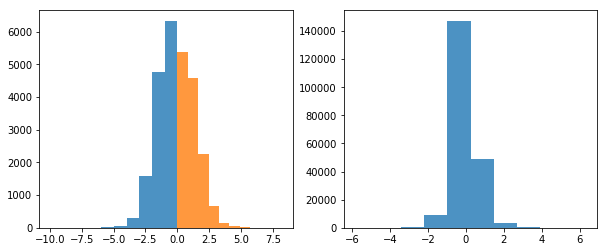

In [77]:
fig = plt.figure(figsize=(10, 4))

fig.add_subplot(121)
plt.hist(docvector_entries_mins, alpha=.8)
plt.hist(docvector_entries_maxs, alpha=.8)

fig.add_subplot(122)
plt.hist(docvector_entries, alpha=.8)
None

# Synthesize  Chromatic training set

In [840]:
samples_per_class = 90
doc2vec_infer_train_steps = 20

In [868]:
# # TODO apparently this JN doesn't even use this... but it should.
# if 'nlp' not in locals():
#     nlp = spacy.load('en')

In [842]:
if 'cursor_chromatic' not in locals() or cursor_chromatic.closed:
    cursor_chromatic = conn_chromatic.cursor()

In [843]:
# Casual Spectator Sports
cursor_chromatic.execute(f"""
    select aid, full_text
    from articles
    where
        nlid in (select nlid from newsletters where nlaid =4)
        AND content_matches_nl_topic
    limit {samples_per_class}
""")

In [844]:
docvecs_neg = list()
docvecs_neg_aids = list()
for row in cursor_chromatic:
    docvecs_neg.append(
        model_d2v.infer_vector(row[1], steps=doc2vec_infer_train_steps)
    )
    docvecs_neg_aids.append(row[0])

docvecs_neg_aids = np.array(docvecs_neg_aids)
docvecs_neg = np.c_[docvecs_neg]

In [845]:
# Unsupervised Learning Daniel Miessler
cursor_chromatic.execute(f"""
    select aid, full_text
    from articles
    where
        nlid in (select nlid from newsletters where nlaid =1)
        AND content_matches_nl_topic
    limit {samples_per_class}
""")

In [846]:
docvecs_pos = list()
docvecs_pos_aids = list()
for row in cursor_chromatic:
    docvecs_pos.append(
        model_d2v.infer_vector(row[1], steps=doc2vec_infer_train_steps)
    )
    docvecs_pos_aids.append(row[0])

docvecs_pos = np.c_[docvecs_pos]
docvecs_pos_aids = np.array(docvecs_pos_aids)

In [847]:
all_docvecs = np.concatenate([docvecs_pos, docvecs_neg])
all_docvecs_aids = np.concatenate((docvecs_pos_aids, docvecs_neg_aids))

# Classifiers

## SVM

In [848]:
X = np.concatenate([docvecs_pos, docvecs_neg])
y = np.concatenate([len(docvecs_pos)*[+1], len(docvecs_neg)*[0]])

In [849]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

In [891]:
pd.DataFrame([
    ['Positive', y_train.sum(), y_test.sum()],
    ['Negative', abs(y_train-1).sum(), abs(y_test-1).sum()]
], columns='Label Train Test'.split()).set_index('Label')

,Train,Test
Label,,
Positive,72,18
Negative,72,18


(144, 36)

In [ ]:
svm.LinearSVC, svm.SVC, svm.NuSVC

In [850]:
%%time
model_str_length = 10
results = list()
for cls in (svm.LinearSVC, svm.SVC, svm.NuSVC):
    svc = cls()

    svc.fit(
        X=X_train,
        y=y_train,
    )
    results.append((
        cls.__name__,
        svc.score(X_train, y_train),
        svc.score(X_test, y_test),
    ))

CPU times: user 77.8 ms, sys: 1.91 ms, total: 79.7 ms
Wall time: 42.4 ms


/Users/mica/anaconda3/envs/doc2vec/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/mica/anaconda3/envs/doc2vec/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

/Users/mica/anaconda3/envs/doc2vec/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [851]:
pd.DataFrame(results, columns=['Model', 'Train Accuracy', 'Test Accuracy']).set_index('Model')

,Train Accuracy,Test Accuracy
Model,,
LinearSVC,0.993056,0.805556
SVC,0.812500,0.833333
NuSVC,0.951389,0.861111


## Keras

In [825]:
class LossHistory(keras.callbacks.Callback):
    # https://keras.io/callbacks/#example-recording-loss-history
    def on_train_begin(self, logs=dict()):
        self.losses = list()
        self.accuracies = list()
        self.val_accs = list()

    def on_epoch_end(self, batch, logs=dict()):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))
        val_loss, val_acc = dnn.evaluate(X_test, y_test)
        self.val_accs.append(val_acc)


In [877]:
dnn_epochs = 300

dnn = keras.Sequential()
dnn.add(keras.layers.Dense(10, input_dim=X.shape[1], activation='relu'))
# dnn.add(keras.layers.Dense(10, activation='sigmoid'))
# dnn.add(keras.layers.Dense(10, activation='relu'))
dnn.add(keras.layers.Dense(30, activation='sigmoid'))
dnn.add(keras.layers.Dense(30, activation='sigmoid'))
dnn.add(keras.layers.Dense(1, activation='sigmoid'))

dnn.compile(
    keras.optimizers.Adagrad(),
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy'],
)
history = LossHistory()
dnn.fit(
    X_train, y_train,
    validation_data=[X_test, y_test],
    epochs=dnn_epochs,
    callbacks=[history],
)


Train on 144 samples, validate on 36 samples
Epoch 1/300
36/36 [==============================] - 0s 159us/step
Epoch 2/300
36/36 [==============================] - 0s 150us/step
Epoch 3/300
36/36 [==============================] - 0s 130us/step
Epoch 4/300
36/36 [==============================] - 0s 160us/step
Epoch 5/300
36/36 [==============================] - 0s 173us/step
Epoch 6/300
36/36 [==============================] - 0s 211us/step
Epoch 7/300
36/36 [==============================] - 0s 157us/step
Epoch 8/300
36/36 [==============================] - 0s 149us/step
Epoch 9/300
36/36 [==============================] - 0s 163us/step
Epoch 10/300
36/36 [==============================] - 0s 143us/step
Epoch 11/300
36/36 [==============================] - 0s 143us/step
Epoch 12/300
36/36 [==============================] - 0s 91us/step
Epoch 13/300
36/36 [==============================] - 0s 153us/step
Epoch 14/300
36/36 [==============================] - 0s 122us/step
Epoch 15/300


KeyboardInterrupt: 

In [80]:
!du -hs ./ML\ Project\ Chromatic\ News.ipynb ./lda2vec.ipynb

204K	./ML Project Chromatic News.ipynb
1.5M	./lda2vec.ipynb


testing accuracy   : 0.785%
validation accuracy: 0.861%


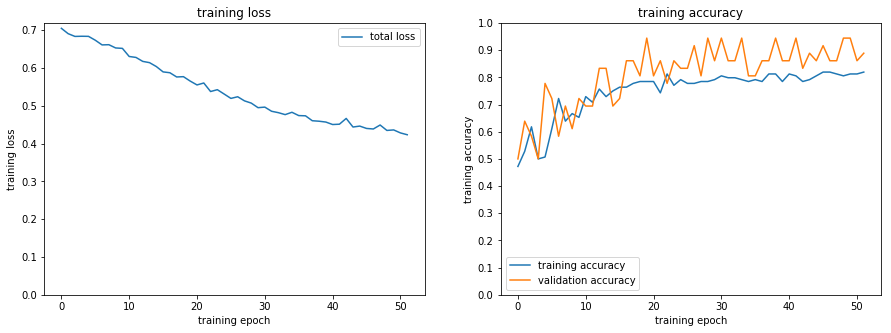

In [878]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
if True:
    losses = history.losses
    plt.plot(
        list(range(len(losses))),
        losses,
        label='total loss',
    )
    plt.legend()
    plt.title('training loss')
    plt.xlabel('training epoch')
    plt.ylabel('training loss')
    _, t = plt.ylim()
    plt.ylim((0, t))

fig.add_subplot(122)
if True:
    accuracies = history.accuracies
    plt.plot(
        list(range(len(accuracies))),
        accuracies,
        label='training accuracy',
    )
    val_accs = history.val_accs
    plt.plot(
        list(range(len(val_accs))),
        val_accs,
        label='validation accuracy',
    )
    plt.title('training accuracy')
    plt.xlabel('training epoch')
    plt.ylabel('training accuracy')
    plt.ylim((0, 1))
    plt.legend()
    step = .1
    plt.yticks(np.arange(0, 1+step, step))
print(f'testing accuracy   : {dnn.evaluate(X_train, y_train, verbose=0)[1]:.3f}%')
print(f'validation accuracy: {dnn.evaluate(X_test, y_test, verbose=0)[1]:.3f}%')


### Review Incorrect Predictions

In [828]:
labels = ['Casual Spectator Sports', "Unsupervised Learning Daniel Miessler"]

incorrect_aid_indices = (dnn.predict(X).reshape(-1)>.5) != y
incorrect_prediction_labels = y[incorrect_aid_indices]
incorrect_aids = all_docvecs_aids[incorrect_aid_indices]

for aid, label in zip(incorrect_aids, incorrect_prediction_labels):
    print(f'update articles set content_matches_nl_topic=false where aid={aid};\n{labels[label]}')
    print(article_text_for_aid(aid, cursor_chromatic))
    print('######################################################################')

update articles set content_matches_nl_topic=false where aid=32;
Unsupervised Learning Daniel Miessler
Please give your feedback on the list here.

The OWASP Internet of Things Top 10 has not been updated since 2014, for a number of reasons. First of which was the fact that we released the new umbrella project that removed focus from the Top 10 format. This, in retrospect, seems to have been a mistake.

The idea was to just make a vulnerability list, and get away from the Top 10 concept.

As it turns out, people like Top 10 lists, and things have changed enough in the last few years that the team has been working this year to update the project for 2018.

This is what we’ve come up with so far, and I wanted to just talk through some of the philosophy and methodology for this year’s release.

Philosophy

So the philosophy we worked under was that of simplicity and practicality. We don’t believe the big data approach works as well as people hope it would, i.e., collecting datasets from h

## Plot: Chromatic training set doc2vec+pca+plot

In [803]:
pca = PCA(3)

In [804]:
projected = pca.fit_transform(all_docvecs)

In [805]:
projected.shape

(180, 3)

In [806]:
docvecs_pos.shape[0]

90

In [893]:
# https://plot.ly/python/3d-scatter-plots/
trace_pos = go.Scatter3d(
    x=projected[:docvecs_pos.shape[0], 0],
    y=projected[:docvecs_pos.shape[0], 1],
    z=projected[:docvecs_pos.shape[0], 2],
    mode='markers',
#     connectgaps=False,
#     line=False,
#     text=use_words,
    surfacecolor='green',
)
trace_neg = go.Scatter3d(
    x=projected[docvecs_pos.shape[0]:, 0],
    y=projected[docvecs_pos.shape[0]:, 1],
    z=projected[docvecs_pos.shape[0]:, 2],
    mode='markers',
#     connectgaps=False,
#     line=False,
#     text=use_words,
    surfacecolor='red',
)


fig = go.Figure(data=[trace_pos, trace_neg])
py.iplot(fig)

/Users/mica/anaconda3/envs/doc2vec/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

